In [1]:
# All the imports
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Loading

### Headers and Label classes

In [2]:
df_X_headers = pd.read_table("features.txt", delim_whitespace=True, header=None, names=["id", "name"])
df_activities = pd.read_table("activity_labels.txt", delim_whitespace=True, header=None, names=["id", "name"])

# convert header df into list of strings by combining ids
headers = ["_".join([str(idx), h[1]]) for (idx, h) in enumerate(df_X_headers.values.tolist())]


### Testing and Training DataFrames

In [3]:
X_train_all = pd.read_table("train/X_train.txt", delim_whitespace=True, header=None, names=headers)
print(X_train_all.shape)

y_train = pd.read_table("train/y_train.txt", delim_whitespace=True, header=None, names=['Label'])
print(y_train.shape)

X_test_all = pd.read_table("test/X_test.txt", delim_whitespace=True, header=None, names=headers)
print(X_test_all.shape)

y_test = pd.read_table("test/y_test.txt", delim_whitespace=True, header=None, names=['Label'])
print(y_test.shape)

print(set(np.ravel(y_train.values)))

(7352, 561)
(7352, 1)
(2947, 561)
(2947, 1)
{1, 2, 3, 4, 5, 6}


---

# Generic Methods

In [4]:
def predict(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predictProb(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)

In [5]:
def accuracy(X_train, y_train, X_test, y_test, model_tuples):
    """
    model_tuples -> [('model description', model_object),...]
    """
    _dict = {desc: accuracy_score(y_test, predict(X_train, y_train, X_test, model)) for (desc, model) in model_tuples}
    df = pd.DataFrame()
    df['Model'], df['Accuracy'] = _dict.keys(), _dict.values()
    return df

def computeROCmatrics(y_test, y_predict_prob, positive_label=1):
    """
    return -> (fpr, tpr, AUC, thresholds)
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,positive_label-1], pos_label=positive_label)
    AUC = metrics.auc(fpr, tpr)
    return (fpr, tpr, AUC, thresholds)

In [6]:

def plotROC_AUC(ax, metrics_list):
    # Colormap
    cmp = plt.cm.get_cmap('hsv', len(metrics_list))
    
    # plot metrics
    for (clr, (cat, fpr, tpr, AUC)) in enumerate(metrics_list):        
        ax.plot(fpr, tpr, color=cmp(clr), lw=2, 
                 label='ROC - {} (area = {:0.2f})'.format(cat, AUC))

    # Random Guess line:
    ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    # Defining The Range of X-Axis and Y-Axis:
    ax.axis(xmin=-0.005,xmax=1.005,ymin=0.0,ymax=1.005)

    # Labels, Legend:
    plt.xlabel('False Positive Rate', axes=ax)
    plt.ylabel('True Positive Rate', axes=ax)
    ax.legend(loc="lower right")

---

# Feature Selection

## Principal Component Analysis

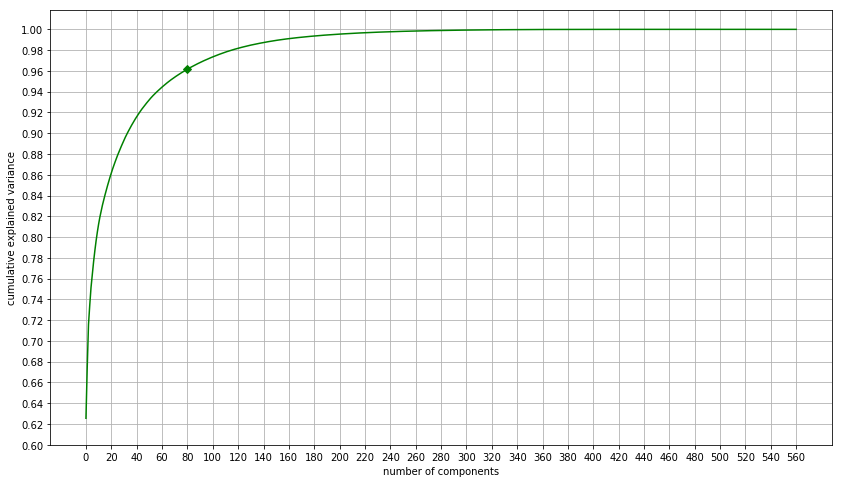

In [42]:
plt.figure(figsize=(14,8))
pca = PCA().fit(X_train_all)
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-gD', markevery=[80])
plt.xticks(np.arange(0, 580, step=20))
plt.yticks(np.arange(0.6, 1.02, step=.02))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### As we can see, we can easily retain 96% of variance using just about 80 features

In [24]:
# Using Variance Threshold
#sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
#sel = sel.fit(X_train_all)

# Using a model fitted on training data and using its 'feature_importances_' attribute to select features
#lsvc = LinearSVC(C=0.005, penalty="l1", dual=False).fit(X_train_all, y_train.values.ravel())
#sel = SelectFromModel(lsvc, prefit=True)

# Using Principal component analysis (PCA)
variance = .96
sel = PCA(variance).fit(X_train_all)#, y_train.values.ravel())
print('Number of Features is reduced from {} to {} (i.e. {:0.2f}%) retaining {}% of variance in data'\
          .format(X_train_all.shape[1], sel.n_components_, sel.n_components_*100/X_train_all.shape[1], variance*100))
X_train = sel.transform(X_train_all)
X_test = sel.transform(X_test_all)

print(X_train.shape)
print(X_test.shape)


Number of Features is reduced from 561 to 79 (i.e. 14.08%) retaining 96.0% of variance in data
(7352, 79)
(2947, 79)


# Analysis

## List of models to be evaluated

In [465]:
model_list = [\
         ("KNeighborsClassifier",KNeighborsClassifier()),\
         ("DecisionTreeClassifier",DecisionTreeClassifier()),\
         ("LogisticRegression",LogisticRegression()),\
         ("RandomForestClassifier", RandomForestClassifier(n_estimators = 19, bootstrap = True))
                                   ]

## Accuracy Comparison using accuracy_score

In [466]:
print("Model Accuracies for a given dataset:")
accuracies = accuracy(X_train, y_train.values.ravel(), X_test, y_test.values.ravel(), model_list)
display(accuracies)

Model Accuracies for a given dataset:


,Model,Accuracy
0,KNeighborsClassifier,0.893451
1,DecisionTreeClassifier,0.800814
2,LogisticRegression,0.946047
3,RandomForestClassifier,0.888361


## Compare the ROC and AUC metrics of models

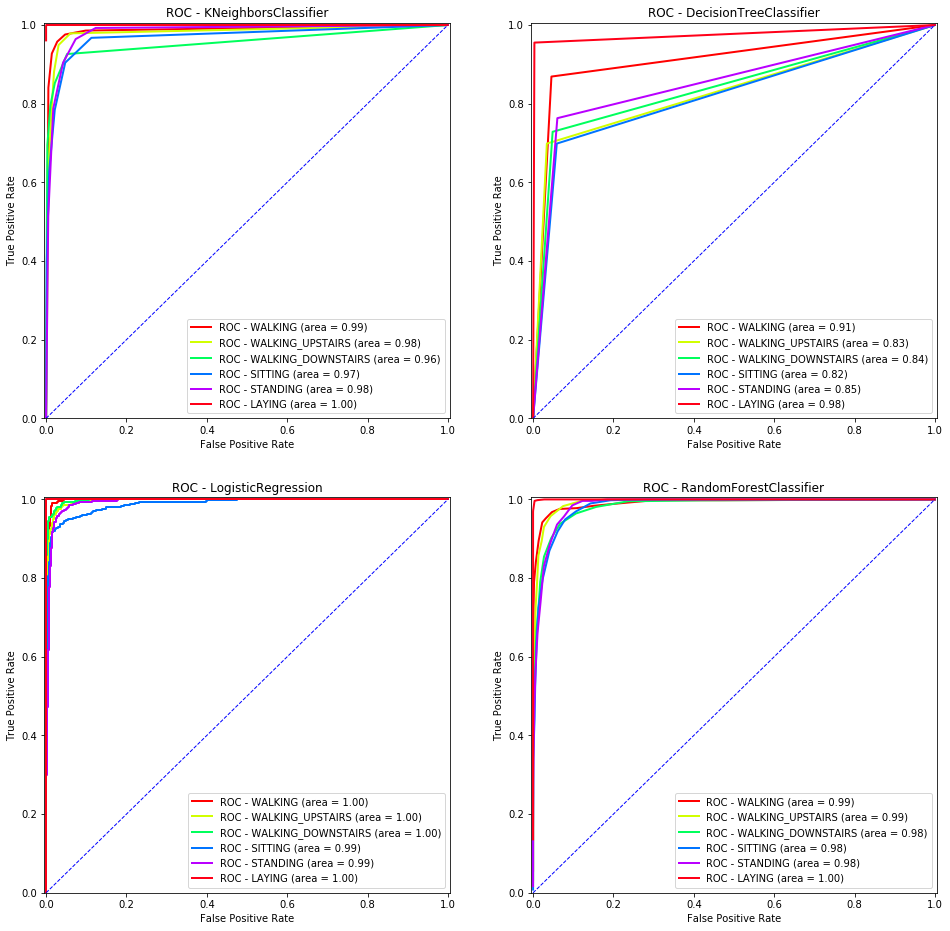

In [467]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for _, (model_name, model_obj) in enumerate(model_list):
    ax = fig.add_subplot(2, 2, _+1)
    ax.set_title('ROC - {}'.format(model_name))
    y_predict_prob = predictProb(X_train, y_train.values.ravel(), X_test, model_obj)
    m = [(df_activities.at[label-1,'name'],) + computeROCmatrics(y_test, y_predict_prob, positive_label=label)[:-1] for label in [1,2,3,4,5,6]]
    plotROC_AUC(ax, m)


---

# Conclusion

#### LoL :P